# ConvNeXt from Scratch in PyTorch

The authors of ConvNeXt did their best to revive ResNet by improving it following new practices and discoveries made in the last decade to perform better and to be more similar to a transformer, without actually turning it into a transformer or adding attention into the mix. The authors focused on Swin-Transformer and follows closely its design choices.

https://arxiv.org/abs/2201.03545

In [ ]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Define configs for different ConvNeXt versions

ResNet-50 has four stages, where stages one and four have three blocks, stage two has four blocks and stage three has six blocks (3, 4, 6, 3). Swin-T also consists of four stages with a ratio of 1:1:3:1 Swin-Transformer Blocks in each stage. Therefore, ConvNeXt adjusts ResNet-50 stages to be more similar to that of the Swin-Transformer, i.e., (3, 3, 9, 3).

In [ ]:
# convnext_= dims (channels), depths (number of blocks at each stage)
model_hparameters= {}
model_hparameters['convnext_tiny']  = ([ 96,192, 384, 768], [3,3, 9,3])  # similar size to resnet50
model_hparameters['convnext_small'] = ([ 96,192, 384, 768], [3,3,27,3])
model_hparameters['convnext_base']  = ([128,256, 512,1024], [3,3,27,3])
model_hparameters['convnext_large'] = ([192,384, 768,1536], [3,3,27,3])
model_hparameters['convnext_xlarge']= ([256,512,1024,2048], [3,3,27,3])

# Architecture Implementation

Starting by the fundamental building block of a CNN, represented by a convolutional layer. ConvNeXt replaces all the Rectified Linear Units (ReLU) in the activation layers with Gaussian Error Linear Units (GELU) as they are smoother and used by Swin Transformers, and replace Batch Normalisation (BN) with Layer Normalisation (LN).

Groups is specified to control how convolution is applied to input. If group=1, then a kernel is applied to all input channels and if group=in_channel (depthwise convolution), then a single convolutional kernel is applied for each input channel.

In [ ]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    ConvNeXt-style: Input -> (pre Norm) -> Conv2d -> (pos Norm) -> Activation -> Output
    - pre_norm only when downsampling (so that the LN sees "old" activations),
    - post_norm -- GroupNorm(1, C, eps) -- everywhere else.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0, groups=1,
                 bias=False, pre_norm=False, post_norm=True, activation=None, eps=1e-6) -> None:
        super(ConvLayer, self).__init__()
        # Pre normalization for the downsample layers (LayerNorm over channels)
        self.pre_norm= nn.GroupNorm(
            num_groups=1, num_channels=in_channels, eps=eps
        ) if pre_norm else None
        # Convolutional module
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias
        )
        # GroupNorm with num_groups=1 is the same as LayerNorm but works for 2D data
        self.post_norm= nn.GroupNorm(
            num_groups=1, num_channels=out_channels, eps=eps
        ) if post_norm else None
        # Activation function -- GELU is the default in ConvNeXt
        self.activation= activation


    def forward(self, x):
        if self.pre_norm is not None:
            x= self.pre_norm(x)
        x= self.conv(x)
        if self.post_norm is not None:
            x= self.post_norm(x)
        if self.activation is not None:
            x= self.activation(x)

        return x


nn.LayerNorm by default expects inputs of shape $[*, D]$ (or more generally it normalizes over the last len(normalized_shape) dimensions). When we do nn.LayerNorm(normalized_shape=$D$) on a tensor of shape $[B, D]$ it computes mean/var over each vector of length $D$. LayerNorm2d (as used in torchvision's ConvNeXt) is really just a version of LayerNorm that works on 4D tensors $[B,C,H,W]$, normalizing across the $C \times H \times W$ dimensions per sample. Under the hood it is implemented using a GroupNorm with G=1 that computes mean/var over all channels and spatial positions — exactly matches what we want for a "2D LayerNorm."

Therefore, by using GroupNorm(num_groups=1, num_channels=C) in our feature extractor, we are doing exactly the same normalization that torchvision calls "LayerNorm2d after the stem and before each pointwise 1x1 conv."

In [ ]:
class StochasticDepth(nn.Module):
    """
    Implements stochastic depth regularization.
    During training, randomly drops the output of the block with probability survival_prob
    scaling the remaining output to maintain the expected value.
    - mode: 'row' to drop per-sample, 'batch' to drop entire batch together.
    """

    def __init__(self, survival_prob, mode='row') -> None:
        super(StochasticDepth, self).__init__()
        assert 0.0 <= survival_prob <= 1.0, "survival_prob must be in [0, 1]"
        assert mode in ('row', 'batch'), "mode must be 'row' or 'batch'"
        self.survival_prob= survival_prob
        self.mode= mode


    def extra_repr(self):
        return f"p={self.survival_prob}, mode={self.mode}"


    def forward(self, x):
        if (not self.training) or self.survival_prob in (0.0, 1.0):
            return x

        if self.mode== 'row':
            # Mask with the same batch size and shape (broadcasted over spatial dimensions)
            mask_shape= (x.shape[0],) + (1,) * (x.ndim - 1)
        else:  # 'batch'
            # Mask for the whole batch
            mask_shape= (1,) * x.ndim

        keep_mask= (torch.rand(mask_shape, device=x.device) < self.survival_prob).type_as(x)
        # Scale the output to maintain expected value and apply the mask
        return torch.div(x, self.survival_prob) * keep_mask


ConvNext uses depthwise convolutions (like in MobileNet and later in EfficientNet). This operation reduces FLOPS and is similar to taking the weighted sum in self-attention, which mixes information only in the spatial dimension.

One important design in every Transformer block is that it creates an **inverted bottleneck**, i.e., the hidden dimension of the FFN block is four times wider than the input dimension. Interestingly, this Transformer design is connected to the inverted bottleneck design with an expansion ratio of 4 used in 1x1 convs. So we go from **wide -> narrow -> wide** to **narrow -> wide -> narrow**. The idea was popularized by MobileNetV2 (InvertedBottleneckBlock), and has subsequently gained traction in several advanced CNN architectures.

However, the depthwise convolutional layer was moved from the center to the first layer in the block, and its kernel size was increased to 7x7.

In Transformer blocks, there is only one activation function, the one inside the MLP block. ConvNeXt reduces the number of activation functions and keeps only the one after the middle conv layer of the inverted bottleneck. Similar to activations, the authors reduced the number of normalization layers, keeping only the one before the middle conv.

In [ ]:
class CNBlock(nn.Module):
    """
    Implements the ConvNeXt Inverted Bottleneck Block with layer scale and stochastic depth.
    """

    def __init__(self, channels, expansion_ratio=4, bias=True, activation=None, drop_path=0.0,
                 layer_scale_init=1e-6) -> None:
        super(CNBlock, self).__init__()
        # Activation function -- GELU is the default in ConvNeXt
        activation= nn.GELU() if activation is None else activation

        # The inverted bottleneck block
        self.bottleneck= nn.Sequential(
            # narrow -> wide (with depthwise conv and bigger kernel)
            ConvLayer(
                channels, channels, kernel_size=7, stride=1, padding=3, groups=channels,
                bias=bias, pre_norm=False, post_norm=True, activation=None
            ),
            # wide -> wide (pointwise -- 1x1 conv)
            ConvLayer(
                channels, channels * expansion_ratio, kernel_size=1, stride=1, padding=0,
                bias=bias, pre_norm=False, post_norm=False, activation=activation
            ),
            # wide -> narrow (projection phase -- 1x1 conv to restore channels)
            ConvLayer(
                channels * expansion_ratio, channels, kernel_size=1, stride=1, padding=0,
                bias=bias, pre_norm=False, post_norm=False, activation=None
            )
        )
        # (optional) layer‐scale (one learnable parameter per channel)
        if layer_scale_init > 0.0:
            self.layer_scaler= nn.Parameter(
                layer_scale_init * torch.ones((channels)), requires_grad=True
            )
        else:
            self.layer_scaler= None
        # For stochastic depth
        self.drop_path= StochasticDepth(drop_path) if drop_path > 0.0 else nn.Identity()


    def forward(self, x):
        # Save the original input for the residual connection
        identity= x
        # Compute the inverted bottleneck block convolutions
        out= self.bottleneck(x)

        if self.layer_scaler is not None:
            # Reshape to [1, C, 1, 1] for broadcasting
            out= self.layer_scaler[None, :, None, None] * out

        out= identity + self.drop_path(out)

        return out


# Building the ConvNeXt

ResNet **stem** uses a very aggressive 7x7 conv and a maxpool to heavily downsample the input images. But the Swin-Transformer uses non-overlapping patches with a 4x4 kernel size. Therefore, the **ConvNeXt** stem is now a 4x4 convolutional layer with a stride of four, so that the patches don't overlap.

In ResNet, downsampling is done using stride=2 convs in the Bottleneck Blocks. Transformers have separate downsampling blocks. Therefore, ConvNeXt removes the stride=2 convs from Bottlenecks and adds **separate downsampling layers between stages** that consist of a layer normalization and a 2x2 conv layer with stride=2.

Finally, ConvNeXt adds a layer normalisation after the average pooling after the fourth stage (before the classification head).

In [ ]:
class ConvNeXt(nn.Module):
    """
    Implements the ConvNeXt architecture.
    """

    def __init__(self, configs, in_channels, num_classes=None, bias=True, activation=None,
                 drop_path=0.1, layer_scale_init=1e-6) -> None:
        super(ConvNeXt, self).__init__()
        # dims (channels) and depths (number of blocks at each stage)
        dims=   configs[0]
        depths= configs[1]
        # Activation function -- GELU is the default in ConvNeXt
        activation= nn.GELU() if activation is None else activation

        # Stem + 3 downsampling layers
        downsample_layers= nn.ModuleList()
        # Stem
        downsample_layers.append(ConvLayer(
            in_channels, dims[0], kernel_size=4, stride=4, padding=0, bias=bias,
            pre_norm=False, post_norm=True, activation=None
        ))
        # and 3 intermediate downsampling ConvLayers
        for i in range(3):
            downsample_layers.append(ConvLayer(
                dims[i], dims[i+1], kernel_size=2, stride=2, padding=0, bias=bias,
                pre_norm=True, post_norm=False, activation=None
            ))

        # 4 feature resolution stages, each consisting of multiple Bottleneck (CN)Blocks
        stages= nn.ModuleList()
        # Create drop path probabilities (one for each stage)
        total_blocks= sum(depths)
        drop_rates= [x.item() for x in torch.linspace(0, drop_path, total_blocks)]
        cur= 0  # current stage (to track how many blocks we've already assigned a drop‑path prob)

        for i in range(4):
            residual_blocks= nn.Sequential(
                *[CNBlock(
                    dims[i], expansion_ratio=4, bias=bias, activation=activation,
                    drop_path=drop_rates[cur + j], layer_scale_init=layer_scale_init
                ) for j in range(depths[i])]
            )
            stages.append(residual_blocks)
            cur += depths[i]  # advance the offset by the number of blocks in this stage

        # The feature extractor is a sequence of downsample_layers and resolution stages
        features= nn.ModuleList()
        for i in range(4):
            features.append(downsample_layers[i])
            features.append(stages[i])

        self.features= nn.Sequential(*features)

        # Pooling and classification head to produce the class logits
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=1)
        self.fc_out= nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.LayerNorm(dims[-1], eps=1e-6),
            nn.Dropout(p=drop_path),
            nn.Linear(dims[-1], num_classes)
        ) if num_classes is not None else None

        # initialize parameters with Xavier
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            if isinstance(m, (nn.GroupNorm, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.features(x)
        x= self.average_pool(x)
        if self.fc_out is not None:
            x= self.fc_out(x)

        return x


In [ ]:
from torchvision import models
from torchvision.models import (
    convnext_tiny,   ConvNeXt_Tiny_Weights,
    convnext_small,  ConvNeXt_Small_Weights,
    convnext_base,   ConvNeXt_Base_Weights,
    convnext_large,  ConvNeXt_Large_Weights,
)

tvis_model= convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 140MB/s]


Number of parameters: 28589128


In [ ]:
img= torch.randn(1, 3, 224, 224).to(device)
model= ConvNeXt(model_hparameters['convnext_tiny'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 28589128
torch.Size([1, 1000])


ConvNeXt(
  (features): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (post_norm): GroupNorm(1, 96, eps=1e-06, affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (bottleneck): Sequential(
          (0): ConvLayer(
            (conv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (post_norm): GroupNorm(1, 96, eps=1e-06, affine=True)
          )
          (1): ConvLayer(
            (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
            (activation): GELU(approximate='none')
          )
          (2): ConvLayer(
            (conv): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (drop_path): Identity()
      )
      (1): CNBlock(
        (bottleneck): Sequential(
          (0): ConvLayer(
            (conv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (post_norm): GroupNorm(1, 96, e

In [ ]:
tvis_model= convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 237MB/s]


Number of parameters: 50223688


In [ ]:
model= ConvNeXt(model_hparameters['convnext_small'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 50223688
torch.Size([1, 1000])


In [ ]:
tvis_model= convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 235MB/s]


Number of parameters: 88591464


In [ ]:
model= ConvNeXt(model_hparameters['convnext_base'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 88591464
torch.Size([1, 1000])


In [ ]:
tvis_model= convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:03<00:00, 234MB/s]


Number of parameters: 197767336


In [ ]:
model= ConvNeXt(model_hparameters['convnext_large'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 197767336
torch.Size([1, 1000])


# Training a ConvNeXt model from scratch

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Strong data augmentation for training.
- Early Stopping: based on validation loss to prevent overfitting.
- Play with different learning rate values.
- More training epochs.
- Larger batch sizes.
- Use label smoothing.

In [ ]:
class CosineLRDecay:
    """
    Modulates learning rate (LR) based on the iteration (step) number which LR there should be.
    """

    def __init__(self, optimizer, min_lr, max_lr=3e-4, warmup_steps=10, max_steps=50) -> None:
        assert warmup_steps < max_steps, "warmup_steps must be less than max_steps"
        self.optimizer= optimizer
        self.min_lr= min_lr
        self.max_lr= max_lr
        self.warmup_steps= warmup_steps
        self.max_steps= max_steps
        self.last_step= 0
        self.last_lr= None


    def get_last_lr(self):
        """ Returns the last computed learning rate. """
        return self.last_lr


    def get_lr(self, it):
        """ Computes the learning rate at a given iteration 'step'. """
        # 1) linear warmup for warmup_iters steps iterations
        if it< self.warmup_steps:
            return self.max_lr * (it + 1) / self.warmup_steps
        # 2) beyond max_steps, use the minimum learning rate
        if it>= self.max_steps:
            return self.min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio= (it - self.warmup_steps) / (self.max_steps - self.warmup_steps)
        assert 0 <= decay_ratio <= 1
        # coeff starts at 1 and goes to 0
        coeff= 0.5 * (1.0 + math.cos(math.pi * decay_ratio))

        return self.min_lr + coeff * (self.max_lr - self.min_lr)


    def step(self):
        """ Updates the learning rate for all parameter groups in the optimizer. """
        self.last_lr= self.get_lr(self.last_step)
        for param_group in self.optimizer.param_groups:
            param_group['lr']= self.last_lr

        self.last_step += 1


In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()
            # for decreasing learning rate -- CosineLRDecay is designed to be used per step
            scheduler.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- ConvNeXt ---
in_channels= 3
num_classes= 10

model= ConvNeXt(model_hparameters['convnext_tiny'], in_channels, num_classes, dropout=0.1).to(device)
count_parameters(model)


# train_loader has size 352, so 40 epochs have 14,080 steps
epochs= 40
steps= len(train_loader) * epochs
learning_rate= 4e-3

max_lr= learning_rate
min_lr= 1e-4
warmup_steps= 704  # 2 epochs of warmup
max_steps= steps

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.05,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= CosineLRDecay(optimizer, min_lr, max_lr, warmup_steps, max_steps)


Number of parameters: 27827818
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 2.7643 | Val Loss: 2.0921 | dt/epoch: 94634.02ms
Epoch: 1 | Train Loss: 1.9494 | Val Loss: 1.8085 | dt/epoch: 93918.41ms
Epoch: 2 | Train Loss: 1.7120 | Val Loss: 1.6304 | dt/epoch: 93957.97ms
Epoch: 3 | Train Loss: 1.6281 | Val Loss: 1.5654 | dt/epoch: 93968.15ms
Epoch: 4 | Train Loss: 1.5670 | Val Loss: 1.5303 | dt/epoch: 93811.53ms
Epoch: 5 | Train Loss: 1.5108 | Val Loss: 1.4614 | dt/epoch: 93924.32ms
Epoch: 6 | Train Loss: 1.4679 | Val Loss: 1.4640 | dt/epoch: 94401.53ms
Epoch: 7 | Train Loss: 1.4229 | Val Loss: 1.4019 | dt/epoch: 94294.41ms
Epoch: 8 | Train Loss: 1.3578 | Val Loss: 1.3850 | dt/epoch: 94223.36ms
Epoch: 9 | Train Loss: 1.3068 | Val Loss: 1.2581 | dt/epoch: 93935.12ms
Epoch: 10 | Train Loss: 1.2546 | Val Loss: 1.2731 | dt/epoch: 93771.58ms
Epoch: 11 | Train Loss: 1.2161 | Val Loss: 1.1955 | dt/epoch: 94157.91ms
Epoch: 12 | Train Loss: 1.1768 | Val Loss: 1.1798 | dt/epoch: 94014.19ms
Epoch: 13 | Train Loss: 1.1458 | Val Loss: 1.1484 | dt/epoch:

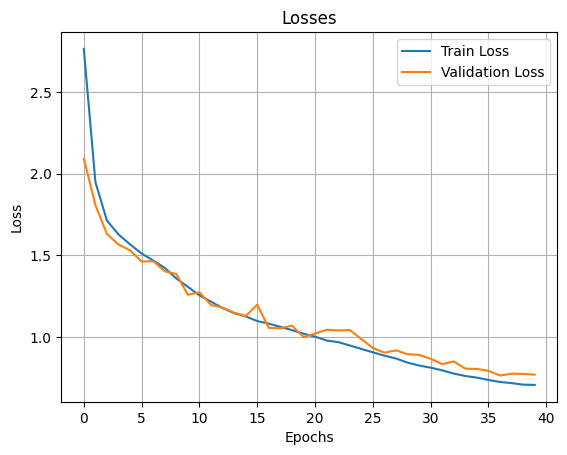

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
convnext_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 73.01%


ConvNeXt needs a "modern" training recipe — strong augmentations, big cosine schedules, carefully adjusted stems and norms — whereas ResNet-50 is more forgiving on a small dataset. The design of ConvNeXt was tuned for large-scale ImageNet-style training. On very small, low-res data, a classic ResNet with the tried-and-true CIFAR tweaks can still win out.



In [ ]:
# https://github.com/facebookresearch/ConvNeXt
# https://github.com/FrancescoSaverioZuppichini/ConvNext
# https://medium.com/towards-data-science/implementing-convnext-in-pytorch-7e37a67abba6
# https://tech.bertelsmann.com/en/blog/articles/convnext?source=post_page325607a08c46
# https://medium.com/@atakanerdogan305/convnext-next-generation-of-convolutional-networks-325607a08c46
# https://medium.com/data-science/residual-bottleneck-inverted-residual-linear-bottleneck-mbconv-explained-89d7b7e7c6bc